In [ ]:
from google.colab import files
files.upload()

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, confusion_matrix,
    RocCurveDisplay, precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [ ]:
with open("clinical.project-tcga-lihc.2025-09-06.json") as f:
    clinical = json.load(f)

print("Loaded", len(clinical), "clinical cases")

Loaded 377 clinical cases


In [ ]:
def recursive_search(d, patterns):
    if isinstance(d, dict):
        for k, v in d.items():
            if any(p in str(k).lower() or p in str(v).lower() for p in patterns):
                return True
            if recursive_search(v, patterns):
                return True
    elif isinstance(d, list):
        for item in d:
            if recursive_search(item, patterns):
                return True
    return False

def extract_label(case):
    if recursive_search(case, ["hepatitis b", "hbv"]):
        return "HBV"
    elif recursive_search(case, ["hepatitis c", "hcv"]):
        return "HCV"
    else:
        return "NonViral"

records = []
for case in clinical:
    records.append({
        "case_id": case.get("submitter_id"),
        "label": extract_label(case)
    })

labels_df = pd.DataFrame(records)
print("Initial class distribution:")
print(labels_df["label"].value_counts())

Initial class distribution:
label
HBV         234
NonViral     97
HCV          46
Name: count, dtype: int64


In [ ]:
labels_df = labels_df[labels_df["label"].isin(["HBV", "NonViral"])].dropna()
print("Filtered to HBV vs NonViral:")
print(labels_df["label"].value_counts())

Filtered to HBV vs NonViral:
label
HBV         234
NonViral     97
Name: count, dtype: int64


In [ ]:
features = []
for case in clinical:
    rec = {"case_id": case.get("submitter_id")}
    diag = case.get("diagnoses", [{}])[0]
    demo = case.get("demographic", {})

    rec["age"] = demo.get("age_at_index")
    rec["gender"] = demo.get("gender")
    rec["stage"] = diag.get("ajcc_pathologic_stage")
    rec["tumor_grade"] = diag.get("tumor_grade")
    features.append(rec)

feat_df = pd.DataFrame(features)

merged = labels_df.merge(feat_df, on="case_id")
print("Merged dataset shape:", merged.shape)
print("Final class distribution:")
print(merged["label"].value_counts())

Merged dataset shape: (331, 6)
Final class distribution:
label
HBV         234
NonViral     97
Name: count, dtype: int64


In [ ]:
stage_map = {
    "Stage I":1, "Stage IA":1, "Stage IB":1,
    "Stage II":2,
    "Stage III":3, "Stage IIIA":3, "Stage IIIB":3, "Stage IIIC":3,
    "Stage IV":4, "Stage IVA":4, "Stage IVB":4
}
grade_map = {"G1":1, "G2":2, "G3":3, "G4":4}

merged["stage_encoded"] = merged["stage"].map(stage_map)
merged["grade_encoded"] = merged["tumor_grade"].map(grade_map)

In [ ]:
X = merged[["age","gender","stage_encoded","grade_encoded"]]
y = merged["label"].map({"HBV":1, "NonViral":0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train distribution:", y_train.value_counts().to_dict())
print("Test distribution:", y_test.value_counts().to_dict())

Train distribution: {1: 163, 0: 68}
Test distribution: {1: 71, 0: 29}


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), ["age"]),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), ["gender"]),

        ("ord", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent"))
        ]), ["stage_encoded","grade_encoded"])
    ]
)

In [ ]:
# Transform training set with preprocessing before SMOTE
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Before SMOTE:", np.bincount(y_train))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)

print("After SMOTE:", np.bincount(y_train_res))

Before SMOTE: [ 68 163]
After SMOTE: [163 163]


In [ ]:
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    scale_pos_weight=len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1]),
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train_res, y_train_res)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:53:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

ROC-AUC: 0.678
F1: 0.792
Accuracy: 0.7
Confusion Matrix:
 [[13 16]
 [14 57]]


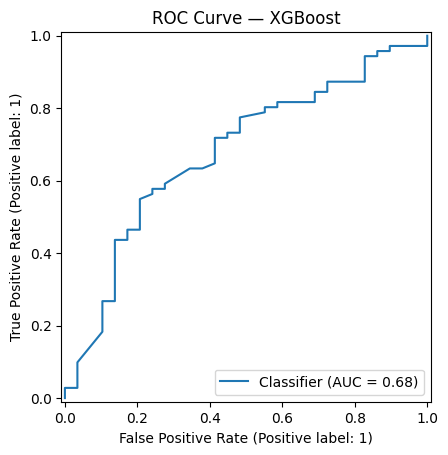

In [ ]:
y_prob = xgb.predict_proba(X_test_proc)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print("ROC-AUC:", round(roc_auc_score(y_test, y_prob),3))
print("F1:", round(f1_score(y_test, y_pred),3))
print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — XGBoost")
plt.show()

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, y_prob)
f1_scores = 2*prec*rec/(prec+rec)
best_idx = f1_scores.argmax()
best_thresh = thresh[best_idx]

print("=== Optimized Threshold ===")
print("Best threshold:", round(best_thresh,3))
print("Best F1 score:", round(f1_scores[best_idx],3))

# Apply optimized threshold
y_pred_opt = (y_prob >= best_thresh).astype(int)
print("Optimized Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))
print("Optimized Accuracy:", round(accuracy_score(y_test, y_pred_opt),3))

=== Optimized Threshold ===
Best threshold: 0.105
Best F1 score: 0.831
Optimized Confusion Matrix:
 [[ 3 26]
 [ 2 69]]
Optimized Accuracy: 0.72


Top 10 Important Features:
         feature  importance
1  gender_female    0.415942
3  stage_encoded    0.212657
0            age    0.201182
4  grade_encoded    0.170218
2    gender_male    0.000000


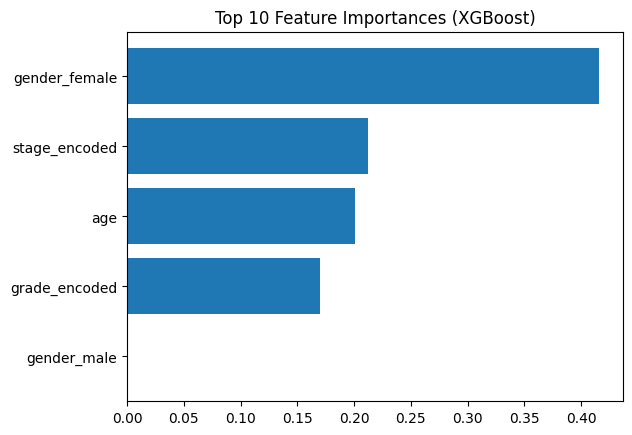

In [ ]:
# Extract categorical feature names after one-hot encoding
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_features = list(ohe.get_feature_names_out(["gender"]))

# Full feature list
feature_names = ["age"] + cat_features + ["stage_encoded","grade_encoded"]

# Map importances
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb.feature_importances_
}).sort_values("importance", ascending=False)

print("Top 10 Important Features:")
print(feat_imp.head(10))

# Plot
plt.barh(feat_imp["feature"].head(10), feat_imp["importance"].head(10))
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

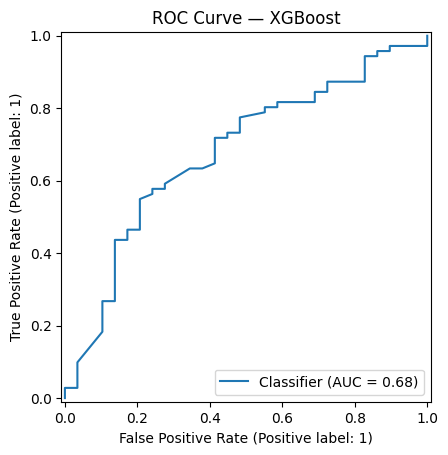

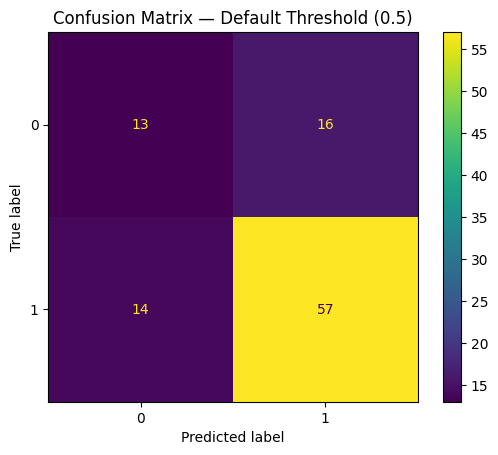

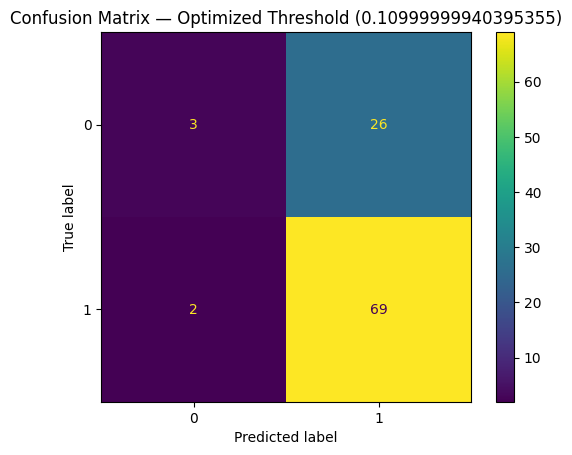

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — XGBoost")
plt.show()

# Confusion matrix (default threshold)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — Default Threshold (0.5)")
plt.show()

# Confusion matrix (optimized threshold)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt)
plt.title(f"Confusion Matrix — Optimized Threshold ({round(best_thresh,2)})")
plt.show()

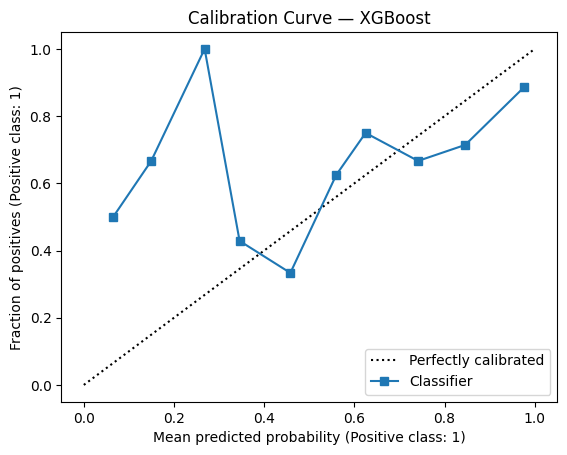

In [ ]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, strategy="uniform")
plt.title("Calibration Curve — XGBoost")
plt.show()

In [21]:
! wget https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-LIHC.star_fpkm-uq.tsv.gz

--2025-09-06 18:28:39--  https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-LIHC.star_fpkm-uq.tsv.gz
Resolving gdc-hub.s3.us-east-1.amazonaws.com (gdc-hub.s3.us-east-1.amazonaws.com)... 52.216.204.238, 52.217.116.74, 54.231.197.234, ...
Connecting to gdc-hub.s3.us-east-1.amazonaws.com (gdc-hub.s3.us-east-1.amazonaws.com)|52.216.204.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100179162 (96M) [text/tab-separated-values]
Saving to: ‘TCGA-LIHC.star_fpkm-uq.tsv.gz’

TCGA-LIHC.star_fpkm 100%[===================>]  95.54M  41.1MB/s    in 2.3s    

2025-09-06 18:28:42 (41.1 MB/s) - ‘TCGA-LIHC.star_fpkm-uq.tsv.gz’ saved [100179162/100179162]



In [23]:
import pandas as pd

# Load expression
expr = pd.read_csv("TCGA-LIHC.star_fpkm-uq.tsv.gz", sep="\t", index_col=0).T

# Harmonize patient barcodes (first 12 chars = case_id)
expr.index = [s[:12] for s in expr.index]
expr = expr.groupby(expr.index).mean()

print("Expression matrix:", expr.shape)

# Align with your clinical dataset
merged_expr = merged.set_index("case_id").join(expr, how="inner")

print("Merged clinical+expression:", merged_expr.shape)
print("Class distribution:\n", merged_expr["label"].value_counts())

Expression matrix: (371, 60660)
Merged clinical+expression: (325, 60667)
Class distribution:
 label
HBV         229
NonViral     96
Name: count, dtype: int64


In [26]:
# Clinical features
# Correct clinical features: use numeric-encoded columns
X_clin = merged_expr[["age", "stage_encoded", "grade_encoded"]].copy()

# Encode gender to numeric (0/1)
X_clin["gender"] = (merged_expr["gender"] == "male").astype(int)

y = merged_expr["label"].map({"HBV":1, "NonViral":0})

In [28]:
# Clinical features
X_clin = merged_expr[["age", "stage_encoded", "grade_encoded"]].copy()
X_clin["gender"] = (merged_expr["gender"] == "male").astype(int)

# Labels
y = merged_expr["label"].map({"HBV":1, "NonViral":0})

# Expression-only: drop any clinical columns that slipped in
expr_only = merged_expr.drop(
    columns=["label", "age", "gender", "stage", "tumor_grade", "stage_encoded", "grade_encoded"],
    errors="ignore"
)

# Select top 500 most variable genes
top_genes = expr_only.var(axis=0).sort_values(ascending=False).head(500).index
X_expr = expr_only[top_genes]

# Combined
X_both = pd.concat([X_clin, X_expr], axis=1)

print("Clinical shape:", X_clin.shape)
print("Expression shape:", X_expr.shape)
print("Combined shape:", X_both.shape)
print("Class distribution:\n", y.value_counts())

Clinical shape: (325, 4)
Expression shape: (325, 500)
Combined shape: (325, 504)
Class distribution:
 label
1    229
0     96
Name: count, dtype: int64


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from xgboost import XGBClassifier
import pandas as pd

def evaluate(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )
    model = XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, eval_metric="auc", use_label_encoder=False
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    return {
        "Modality": label,
        "ROC-AUC": round(roc_auc_score(y_test, y_prob),3),
        "F1": round(f1_score(y_test, y_pred),3),
        "Accuracy": round(accuracy_score(y_test, y_pred),3)
    }

results = []
results.append(evaluate(X_clin, y, "Clinical-only"))
results.append(evaluate(X_expr, y, "Expression-only"))
results.append(evaluate(X_both, y, "Clinical+Expression"))

results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:36:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:36:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:36:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              Modality  ROC-AUC     F1  Accuracy
0        Clinical-only    0.702  0.803     0.714
1      Expression-only    0.676  0.815     0.704
2  Clinical+Expression    0.685  0.818     0.714


In [30]:
from sklearn.linear_model import LogisticRegressionCV

lasso = LogisticRegressionCV(
    Cs=10, cv=5, penalty="l1", solver="saga",
    max_iter=3000, scoring="roc_auc"
)
lasso.fit(X_expr, y)

# Non-zero genes = minimal signature
selected_genes = X_expr.columns[(lasso.coef_ != 0).ravel()]
print("Minimal signature size:", len(selected_genes))
print("Selected genes (up to 20):", list(selected_genes)[:20])

# Evaluate the reduced set
results.append(evaluate(X_expr[selected_genes], y, "Minimal Signature"))
results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Minimal signature size: 30
Selected genes (up to 20): ['ENSG00000160868.15', 'ENSG00000255974.8', 'ENSG00000130649.10', 'ENSG00000163993.7', 'ENSG00000129824.16', 'ENSG00000244067.3', 'ENSG00000140107.12', 'ENSG00000226278.1', 'ENSG00000021826.17', 'ENSG00000133636.11', 'ENSG00000211598.2', 'ENSG00000167910.4', 'ENSG00000247627.2', 'ENSG00000109181.12', 'ENSG00000167244.21', 'ENSG00000164120.14', 'ENSG00000205362.11', 'ENSG00000115457.10', 'ENSG00000221867.9', 'ENSG00000259803.7']


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:38:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              Modality  ROC-AUC     F1  Accuracy
0        Clinical-only    0.702  0.803     0.714
1      Expression-only    0.676  0.815     0.704
2  Clinical+Expression    0.685  0.818     0.714
3    Minimal Signature    0.706  0.844     0.755


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:41:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


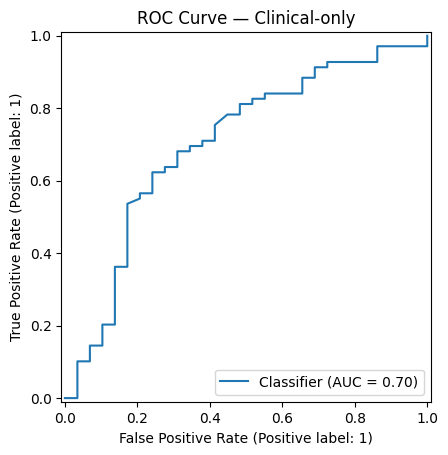

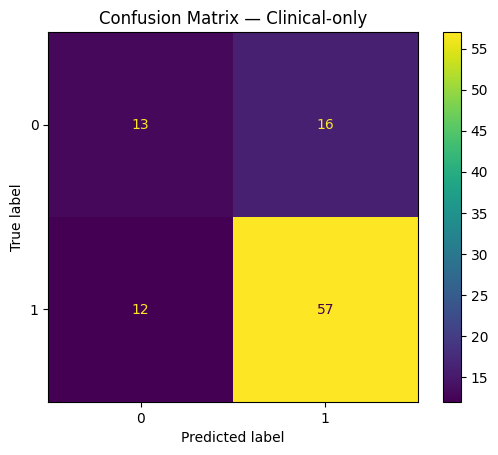

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:41:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


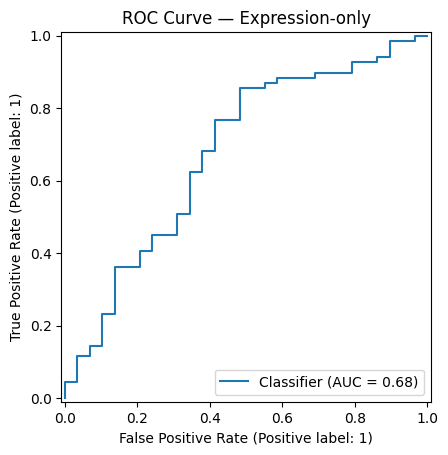

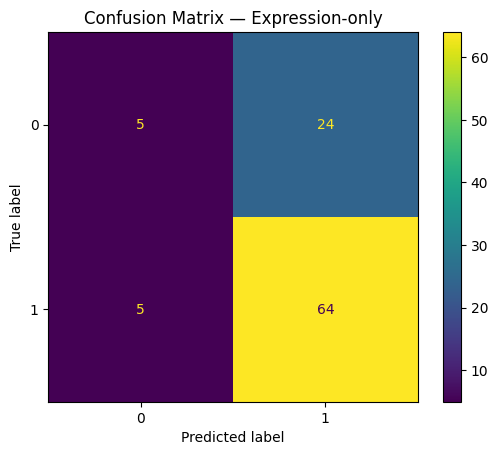

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:41:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


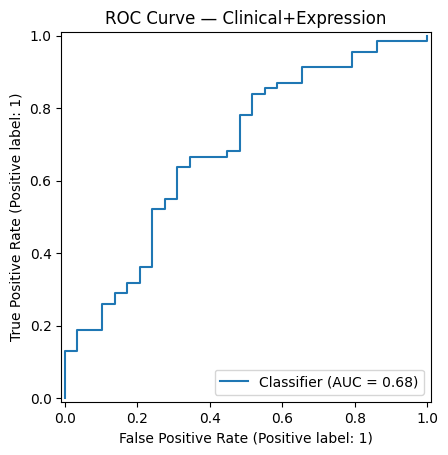

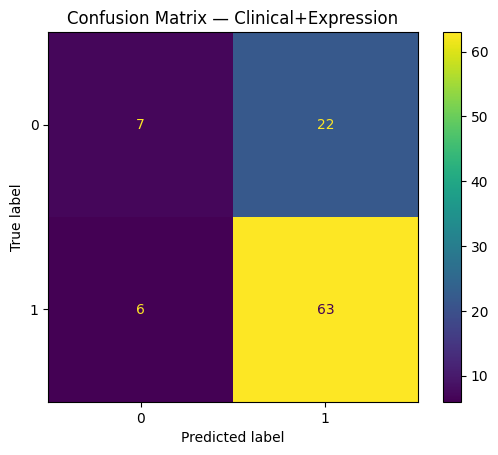

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:41:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


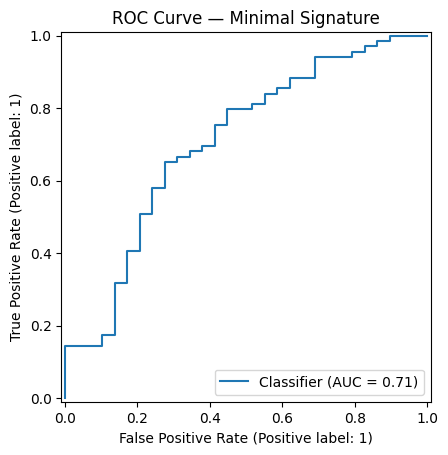

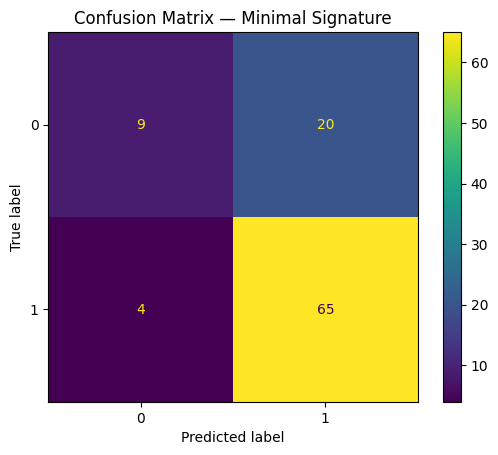

,Modality,ROC-AUC,F1,Accuracy
0,Clinical-only,0.702,0.803,0.714
1,Expression-only,0.676,0.815,0.704
2,Clinical+Expression,0.685,0.818,0.714
3,Minimal Signature,0.706,0.844,0.755


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

def evaluate_with_plots(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )
    model = XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, eval_metric="auc", use_label_encoder=False
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve — {label}")
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix — {label}")
    plt.show()

    return {
        "Modality": label,
        "ROC-AUC": round(roc_auc_score(y_test, y_prob),3),
        "F1": round(f1_score(y_test, y_pred),3),
        "Accuracy": round(accuracy_score(y_test, y_pred),3)
    }

# Run for each modality
plot_results = []
plot_results.append(evaluate_with_plots(X_clin, y, "Clinical-only"))
plot_results.append(evaluate_with_plots(X_expr, y, "Expression-only"))
plot_results.append(evaluate_with_plots(X_both, y, "Clinical+Expression"))
plot_results.append(evaluate_with_plots(X_expr[selected_genes], y, "Minimal Signature"))

pd.DataFrame(plot_results)

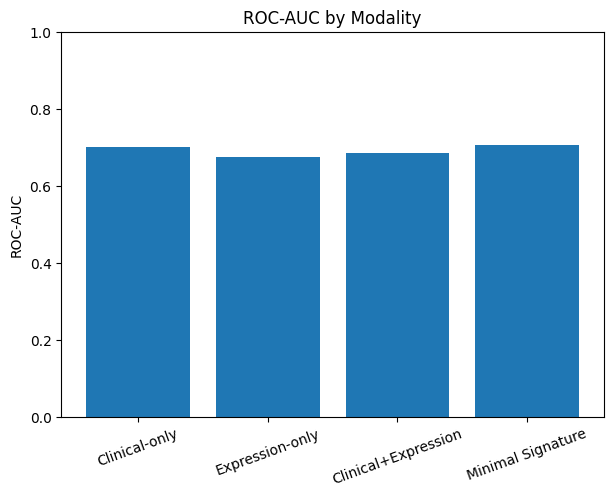

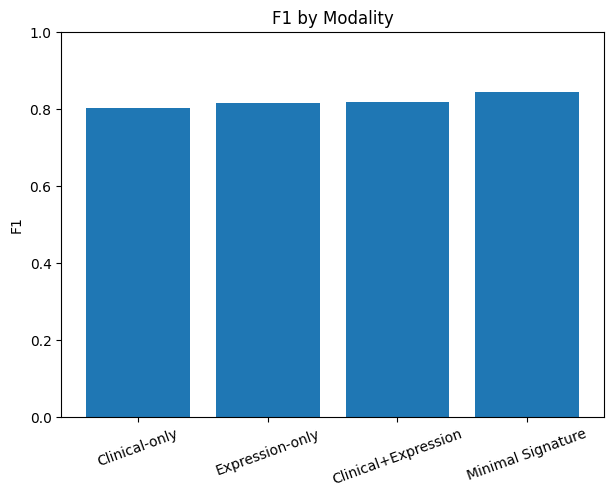

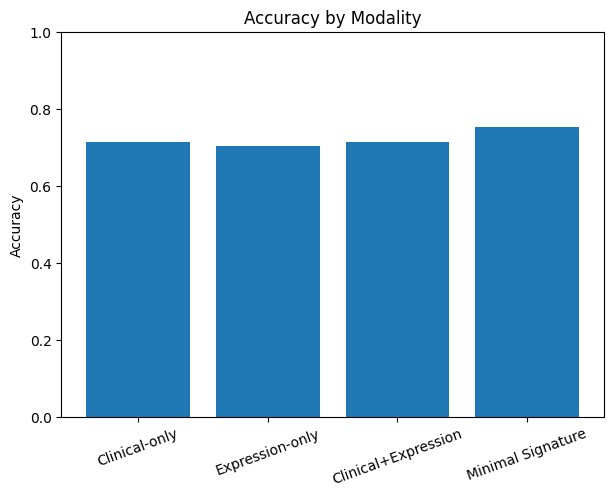

In [32]:
import numpy as np

# Convert results into DataFrame if not already
metrics_df = pd.DataFrame(plot_results)

# Plot each metric as grouped bars
metrics = ["ROC-AUC", "F1", "Accuracy"]

for metric in metrics:
    plt.figure(figsize=(7,5))
    plt.bar(metrics_df["Modality"], metrics_df[metric])
    plt.title(f"{metric} by Modality")
    plt.ylabel(metric)
    plt.ylim(0,1)   # keep scale consistent
    plt.xticks(rotation=20)
    plt.show()

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:43:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


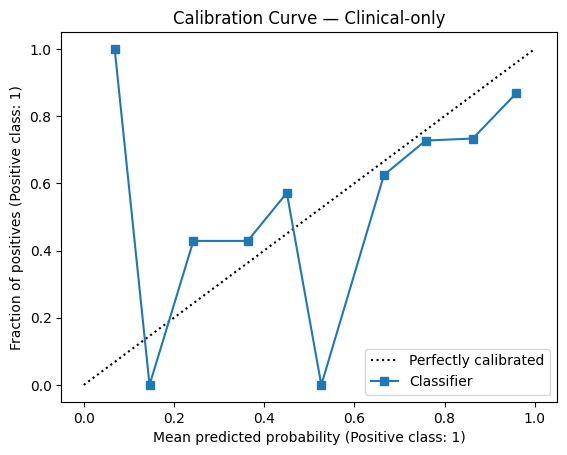

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:43:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


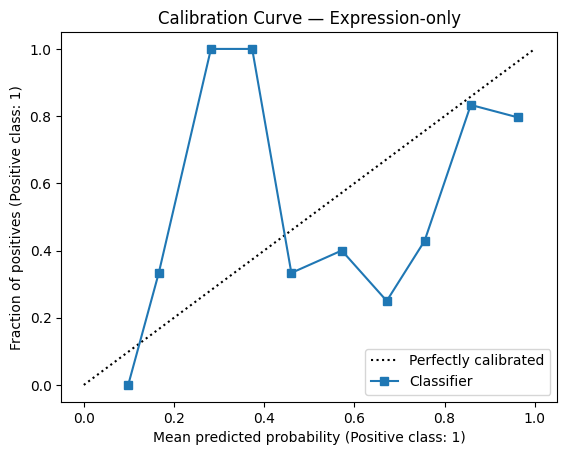

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


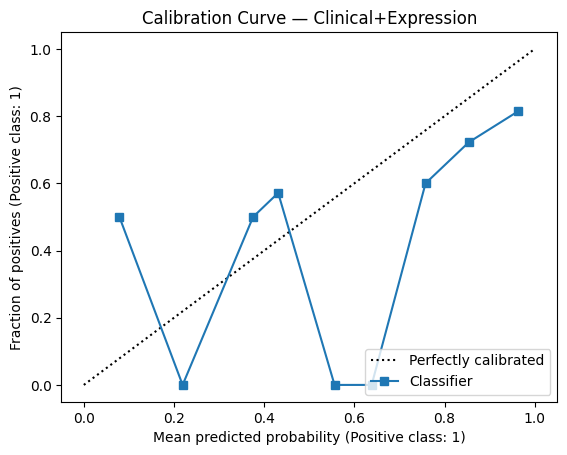

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:43:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


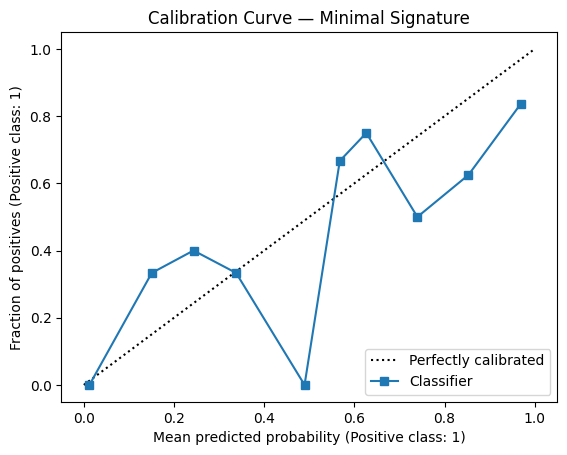

In [33]:
from sklearn.calibration import CalibrationDisplay

def plot_calibration(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )
    model = XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, eval_metric="auc", use_label_encoder=False
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]

    CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, strategy="uniform")
    plt.title(f"Calibration Curve — {label}")
    plt.show()

# Run calibration plots for each modality
plot_calibration(X_clin, y, "Clinical-only")
plot_calibration(X_expr, y, "Expression-only")
plot_calibration(X_both, y, "Clinical+Expression")
plot_calibration(X_expr[selected_genes], y, "Minimal Signature")

In [34]:
def evaluate_full(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )
    model = XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, eval_metric="auc", use_label_encoder=False
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)

    return {
        "Modality": label,
        "ROC-AUC": round(roc_auc_score(y_test, y_prob),3),
        "F1": round(f1_score(y_test, y_pred),3),
        "Accuracy": round(accuracy_score(y_test, y_pred),3)
    }

# Collect results
final_results = []
final_results.append(evaluate_full(X_clin, y, "Clinical-only"))
final_results.append(evaluate_full(X_expr, y, "Expression-only"))
final_results.append(evaluate_full(X_both, y, "Clinical+Expression"))
final_results.append(evaluate_full(X_expr[selected_genes], y, "Minimal Signature"))

final_df = pd.DataFrame(final_results)
print("=== Final Summary Table ===")
print(final_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:44:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:44:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:44:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:44:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Final Summary Table ===
              Modality  ROC-AUC     F1  Accuracy
0        Clinical-only    0.702  0.803     0.714
1      Expression-only    0.676  0.815     0.704
2  Clinical+Expression    0.685  0.818     0.714
3    Minimal Signature    0.706  0.844     0.755


In [35]:
X_sig = X_expr[selected_genes]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sig, y, stratify=y, test_size=0.3, random_state=42
)

In [37]:
xgb_sig = XGBClassifier(
    n_estimators=400, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="auc", use_label_encoder=False
)
xgb_sig.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

In [39]:
import joblib

joblib.dump(xgb_sig, "xgb_minimal_signature.pkl")

['xgb_minimal_signature.pkl']

In [40]:
joblib.dump(list(selected_genes), "minimal_signature_genes.pkl")

print("Saved: xgb_minimal_signature.pkl + minimal_signature_genes.pkl")

Saved: xgb_minimal_signature.pkl + minimal_signature_genes.pkl


In [52]:
import gradio as gr
import pandas as pd
import joblib

# Load trained model and minimal gene list
xgb_model = joblib.load("xgb_minimal_signature.pkl")
minimal_genes = joblib.load("minimal_signature_genes.pkl")

In [53]:
def predict_hbv(**kwargs):
  input_df = pd.DataFrame([kwargs])
  prob = xgb_model.predict_proba(input_df)[:, 1][0]
  label = "HBV-induced HCC" if prob >= 0.5 else "Non-viral HCC"
  return {"Predicted Probability": float(prob), "Prediction": label}

In [60]:
# Save artifacts for Gradio app
import joblib

X_sig = X_expr[selected_genes]
X_train, X_test, y_train, y_test = train_test_split(
    X_sig, y, stratify=y, test_size=0.3, random_state=42
)

xgb_sig = XGBClassifier(
    n_estimators=400, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, eval_metric="auc", use_label_encoder=False
)
xgb_sig.fit(X_train, y_train)

joblib.dump(xgb_sig, "xgb_minimal_signature.pkl")
joblib.dump(list(X_train.columns), "minimal_signature_genes.pkl")
joblib.dump(X_train.mean(), "minimal_signature_means.pkl")
print("Saved minimal signature model, gene list, and mean values.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:11:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved minimal signature model, gene list, and mean values.
